In [2]:
import tensorflow
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

In [3]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

In [4]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

def create_deep_conv_ae():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (7, 7), activation='relu', padding='same')(x)

    # На этом моменте представление  (7, 7, 1) т.е. 49-размерное

    input_encoded = Input(shape=(7, 7, 1))
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

c_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 7, 7, 1)           24385     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         24385     
Total params: 48,770
Trainable params: 48,770
Non-trainable params: 0
_________________________________________________________________


In [5]:
c_autoencoder.fit(x_train, x_train,
                epochs=64,
                batch_size=16,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/64
3750/3750 [==============================] - 34s 7ms/step - loss: 0.0909 - val_loss: 0.0744
Epoch 2/64
3750/3750 [==============================] - 27s 7ms/step - loss: 0.0739 - val_loss: 0.0719
Epoch 3/64
3750/3750 [==============================] - 30s 8ms/step - loss: 0.0721 - val_loss: 0.0709
Epoch 4/64
3750/3750 [==============================] - 31s 8ms/step - loss: 0.0713 - val_loss: 0.0703
Epoch 5/64
3750/3750 [==============================] - 31s 8ms/step - loss: 0.0707 - val_loss: 0.0698
Epoch 6/64
3750/3750 [==============================] - 31s 8ms/step - loss: 0.0703 - val_loss: 0.0700
Epoch 7/64
3750/3750 [==============================] - 31s 8ms/step - loss: 0.0701 - val_loss: 0.0691
Epoch 8/64
3750/3750 [==============================] - 30s 8ms/step - loss: 0.0699 - val_loss: 0.0690
Epoch 9/64
3750/3750 [==============================] - 30s 8ms/step - loss: 0.0697 - val_loss: 0.0688
Epoch 10/64
3750/3750 [==============================] - 30s 8ms/step - l

In [6]:
c_autoencoder.save('c_autoencoder.h5')
c_encoder.save('c_encoder.h5')
c_decoder.save('c_decoder.h5')

In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

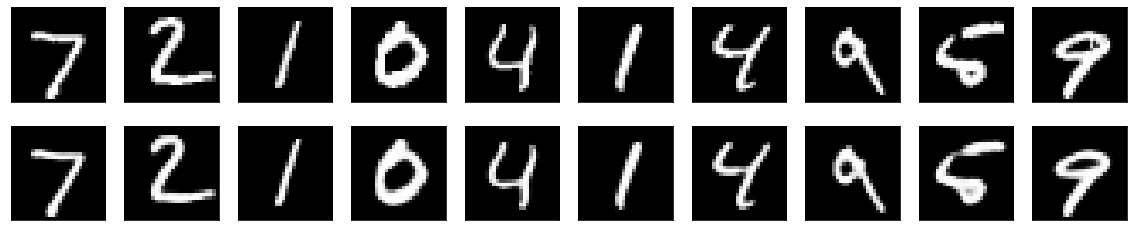

In [8]:
n = 10

imgs = x_test[:n]
encoded_imgs = c_encoder.predict(imgs, batch_size=n)
decoded_imgs = c_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)